In [1]:
import nle.dataset as nld
from nle.nethack import tty_render
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
import seaborn as sns
from scipy.stats import ttest_ind

In [2]:
# path to dataset
nld_nao_path = "/code/nld-nao/nld-nao-unzipped"

# name database
dbfilename = "nld-nao.db"

# name dataset
dataset_name = "nld-nao"

# connect database to 
db_conn = nld.db.connect(filename=dbfilename)
print(f"AltOrg Dataset has {nld.db.count_games('nld-nao', conn=db_conn)} games.")

AltOrg Dataset has 1511228 games.


In [3]:
# Build the subselect sql query
subselect_sql = """
SELECT * 
FROM games 
WHERE name IN (SELECT name FROM games WHERE death = 'ascended' GROUP BY name HAVING COUNT(*) >= 1)"""


In [4]:
# Build Dataset 
# Dataframe of 500 players who have ascended 1 time (experts identified in this) 

# read dateframe from sql query
df = pd.read_sql(subselect_sql, db_conn)  
# Display the DataFrame with the first ten players
# print(f"Number of unique players who have ascended at least one time: {df['name'].nunique()}")
# Convert Unix time columns to datetime
df['starttime'] = pd.to_datetime(df['starttime'], unit='s')
df['endtime'] = pd.to_datetime(df['endtime'], unit='s')

# Reorder the dataframe columns to put name in front
column_to_move = 'name'
new_columns_order = [column_to_move] + [col for col in df.columns if col != column_to_move]
df = df[new_columns_order] 


# Group by player name and select the first 1000 unique players
select_players = df['name'].unique()[:1000]

# Filter the original DataFrame to include only the first ten players
ascended_df = df[df['name'].isin(select_players)]

data = ascended_df.sort_values(by=['name','starttime'])

# Save to File
data.to_csv('datasets/df.csv', index=False)  

# Display the DataFrame with the first ten players
print(f"Number of Selected players: {data['name'].nunique()}")

Number of Selected players: 1000


In [5]:
# Add Game duration column
data['game_duration'] = data['endtime'] - data['starttime']

# Calculate the entire history of gameplay 
# Group by player name and calculate min starttime and max endtime
time_diff = df.groupby('name').agg(min_starttime=('starttime', 'min'), max_endtime=('endtime', 'max')
)

# Calculate the difference
time_diff['time_difference'] = time_diff['max_endtime'] - time_diff['min_starttime']

# Merge the original DataFrame with the time difference DataFrame
df = pd.merge(df, time_diff, on='name')

# Drop extra rows
df = df.drop('min_starttime', axis=1)
df = df.drop('max_endtime', axis=1)


# TODO: Add More Column information 


In [10]:
def create_sequences(data, n, k):
    sequences = []
    labels = []
    for player in data['name'].unique():
        player_data = data[data['name'] == player].sort_values(by='starttime')
        for i in range(len(player_data) - n - k + 1):
            sequence = player_data.iloc[i:i+n]
            label = 1 if player_data.iloc[i+n:i+n+k]['death'].eq('ascended').any() else 0
            sequences.append(sequence)
            labels.append(label)
    return sequences, labels

# Define your parameters for n and k
n = 5  # Number of games to consider in the window
k = 3  # Number of games to predict into the future
sequences, labels = create_sequences(data, n, k)

def extract_features(sequence):
    # Example features
    avg_points = sequence['points'].mean()
    max_points = sequence['points'].max()
    std_points = sequence['points'].std()
    max_level = sequence['maxlvl'].max()
    return pd.Series([avg_points, max_points, std_points, max_level], 
                     index=['avg_points', 'max_points', 'std_points', 'max_level'])

# Ensure sequences is properly created before using it here
features = pd.DataFrame([extract_features(seq) for seq in sequences])

In [7]:
# Function to find high-frequency gameplay periods
# Identify periods of high gameplay frequency given a player
# Parameters: Dataframe, rolling window size in days, threshold to determine number of games in a window 
# Returns: list of tim periods with high frequency gameplay 
def high_frequency_periods(df, window_size='30D', threshold=10):
    # Resample or calculate rolling count of games
    df['game_count'] = df['starttime'].dt.to_period('D')  # Convert to daily periods
    rolling_counts = df.set_index('starttime').resample(window_size)['game_count'].count()  # Rolling window count

    # Identify high-frequency periods
    high_freq_periods = rolling_counts[rolling_counts >= threshold].index
    return high_freq_periods

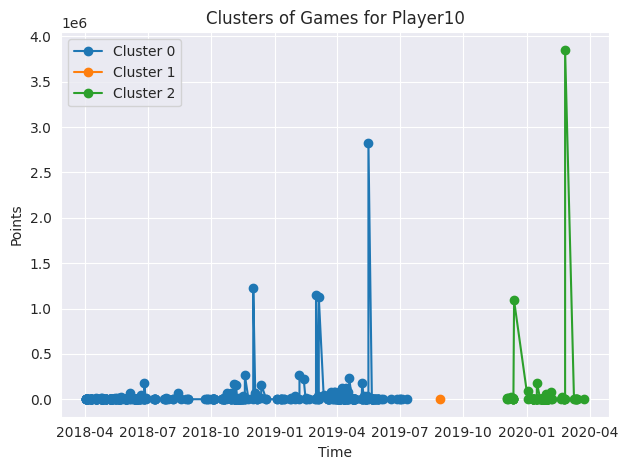

In [16]:
# Clusters games in a dataframe into clusters based on threshold
# Clustering Method 1 - Thresholding sequences of games
def cluster_sequences(df, time_gap_threshold=30):
    
    # For each Player: Calculate the time difference (in days) between consecutive games
    df['time_diff'] = df.groupby('name')['starttime'].diff().dt.days
    
    # Add labels with a large time difference and compare to threshold
    df['large_gap'] = df['time_diff'] > time_gap_threshold
    
    # Create clusters based on the groups of games separated by this time gap threshold
    df['cluster'] = df.groupby('name')['large_gap'].cumsum()
    
    # Drop the extra columns used to calculate the clusters
    df = df.drop(columns=['large_gap', 'time_diff'])
    
    # Return dataframe with columns cluster
    return df


clustered_data = cluster_sequences(data, time_gap_threshold=30)

clusters = clustered_data.groupby(['name', 'cluster'])

player_clusters = clusters.get_group(('Player10', 1))  # Example: Get cluster 1 for Player10

# You can further analyze or plot the data based on the clusters
# Example: Plot points for Player1's different clusters
player_name = 'Player10'

for cluster_id, group in data[data['name'] == player_name].groupby('cluster'):
    plt.plot(group['starttime'], group['points'], marker='o', label=f'Cluster {cluster_id}')

plt.xlabel('Time')
plt.ylabel('Points')
plt.title(f'Clusters of Games for {player_name}')
plt.legend()
plt.tight_layout()
plt.show()

In [17]:
# Cluster extraction
def extract_clusters(data, player_name):
    
    # Filter data for the specified player
    player_data = data[data['name'] == player_name].copy()
    
    # Sort data by starttime within each cluster
    player_data = player_data.sort_values(by=['cluster', 'starttime'])
    
    # Modify Statistics to create optimality
    cluster_stats = player_data.groupby('cluster').agg(
        total_points=('points', 'sum'),
        avg_points=('points', 'mean'),
        std_points=('points', 'std'),  
        max_level=('maxlvl', 'max'),
        avg_level=('maxlvl', 'mean'),
        std_level=('maxlvl', 'std'),    
        total_turns=('turns', 'sum'),
        avg_turns=('turns', 'mean'),
        std_turns=('turns', 'std'),    
        game_count=('points', 'count'),
        cluster_duration_days=(lambda x: (x['endtime'].max() - x['starttime'].min()).days)
    ).reset_index()
    
    # variation metrics
    cluster_stats['variation_points'] = cluster_stats['std_points'] / cluster_stats['avg_points']
    cluster_stats['variation_levels'] = cluster_stats['std_level'] / cluster_stats['avg_level']
    cluster_stats['variation_turns'] = cluster_stats['std_turns'] / cluster_stats['avg_turns']
    

    return player_data, cluster_stats

player_name = 'Player10'
player_data, cluster_stats = extract_clusters(clustered_data, player_name=player_name)


# def plot_cluster_trends(player_data, cluster_column='cluster', metric='points'):
#     # Create a scatter plot of the chosen metric over time, colored by cluster
#     plt.figure(figsize=(14, 8))
#     sns.scatterplot(x='starttime', y=metric, hue=cluster_column, data=player_data, palette='tab10', s=100)
#     
#     plt.title(f'Clusters of Games for {player_data["name"].unique()[0]}')
#     plt.xlabel('Start Time')
#     plt.ylabel(metric.capitalize())
#     plt.legend(title=cluster_column, bbox_to_anchor=(1.05, 1), loc='upper left')
#     plt.tight_layout()
#     plt.show()
#     
#     
# plot_cluster_trends(player_data, metric='points')
# 
# print(cluster_stats)

TypeError: Must provide 'func' or tuples of '(column, aggfunc).

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

data['points_trend'] = data.groupby('name')['points'].transform(lambda x: np.polyfit(range(len(x)), x, 1)[0])
data['maxlvl_trend'] = data.groupby('name')['maxlvl'].transform(lambda x: np.polyfit(range(len(x)), x, 1)[0])

# Aggregate features by player
player_features = data.groupby('name').agg({
    'points_trend': 'mean',
    'maxlvl_trend': 'mean',
    'points': ['mean', 'std'],
    'maxlvl': ['mean', 'std']
}).reset_index()

scaler = StandardScaler()
# Flatten the MultiIndex columns
player_features.columns = ['_'.join(col).strip() for col in player_features.columns.values]

# Now you can drop the 'name' column without warnings
scaled_features = scaler.fit_transform(player_features.drop('name_', axis=1))
player_features = pd.DataFrame(scaled_features)

kmeans = KMeans(n_clusters=5, random_state=42)
player_features['cluster'] = kmeans.fit_predict(scaled_features)


In [1]:
# Trend Analysis
maxlvl_increase_sql = """
WITH LevelChange AS (
    SELECT 
        name,
        gameid,
        maxlvl,
        starttime,
        LEAD(maxlvl) OVER (PARTITION BY name ORDER BY starttime) - maxlvl AS level_diff
    FROM games
),

UpwardTrend AS (
    SELECT
        name,
        COUNT(CASE WHEN level_diff > 0 THEN 1 END) AS positive_diff_count,
        COUNT(CASE WHEN level_diff < 0 THEN 1 END) AS negative_diff_count,
        COUNT(*) AS total_games
    FROM LevelChange
    GROUP BY name
    HAVING COUNT(CASE WHEN level_diff > 0 THEN 1 END) >= (COUNT(*) * 0.65)  -- Players with an upward trend in at least 80% of their games
)

SELECT 
    g.*
FROM
    games g
JOIN
    UpwardTrend ut ON g.name = ut.name
ORDER BY
    g.name, g.starttime
"""

# Execute the query and load the data into a pandas DataFrame
trend_data = pd.read_sql_query(maxlvl_increase_sql, db_conn)
trend_data

NameError: name 'pd' is not defined

In [23]:
def bin_players(df, metric, method='quantile', thresholds=None, zscore_threshold=1):
    # Calculate player-level performance metrics
    player_metrics = df.groupby('name')[metric].mean().reset_index()
    
    if method == 'quantile':
        # Use quantiles to determine thresholds
        lower_bound = df[metric].quantile(1/3)
        upper_bound = df[metric].quantile(2/3)
    
        # Categorize players based on thresholds
        beginners = player_metrics[player_metrics[metric] <= lower_bound]['name']
        intermediates = player_metrics[(player_metrics[metric] > lower_bound) & (player_metrics[metric] <= upper_bound)]['name']
        advanced = player_metrics[player_metrics[metric] > upper_bound]['name']
    
    elif method == 'thresholds' and thresholds is not None:
        # Use thresholds provided as input
        lower_bound, upper_bound = thresholds
        
        beginners = player_metrics[player_metrics[metric] <= lower_bound]['name']
        intermediates = player_metrics[(player_metrics[metric] > lower_bound) & (player_metrics[metric] <= upper_bound)]['name']
        advanced = player_metrics[player_metrics[metric] > upper_bound]['name']
    
    elif method == 'zscore':
        # Z-score method to measure performance deviation from the mean
        mean_metric = player_metrics[metric].mean()
        std_metric = player_metrics[metric].std()
        
        # Calculate z-scores for each player
        player_metrics['zscore'] = (player_metrics[metric] - mean_metric) / std_metric
        
        beginners = player_metrics[player_metrics['zscore'] <= -zscore_threshold]['name']
        intermediates = player_metrics[(player_metrics['zscore'] > -zscore_threshold) & (player_metrics['zscore'] <= zscore_threshold)]['name']
        advanced = player_metrics[player_metrics['zscore'] > zscore_threshold]['name']
    
    elif method == 'more':
        custom_metric = df.groupby('name')['turns'].mean().reset_index()  
        lower_bound = custom_metric['turns'].quantile(1/3)
        upper_bound = custom_metric['turns'].quantile(2/3)
        
        beginners = custom_metric[custom_metric['turns'] <= lower_bound]['name']
        intermediates = custom_metric[(custom_metric['turns'] > lower_bound) & (custom_metric['turns'] <= upper_bound)]['name']
        advanced = custom_metric[custom_metric['turns'] > upper_bound]['name']
    
    else:
        raise ValueError("Invalid method or thresholds not provided")
    
    return beginners, intermediates, advanced


beginners, intermediates, advanced = bin_players(data, metric='points', method='zscore')

print(f"Beginner Players: {beginners.nunique()}")
print(f"Intermediate Players: {intermediates.nunique()}")
print(f"Advanced Players: {advanced.nunique()}")

Beginner Players: 0
Intermediate Players: 978
Advanced Players: 22
